In [1]:
#!/usr/bin/env python

# heatwave_cities.ipynb

'''
    File name: conditions_WBGT_monthmax.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.30.2024
    Date last modified: 04.30.2024

    ############################################################## 
    Needs data from:
    papers/2024/2024_WBGT_Climate-Change/programs/city_analysis/city_analysis.py
    papers/2024/2024_WBGT_Climate-Change/programs/conditions_WBGT/conditions_WBGT_monthmax-warming-targets.py
    
    Purpose:

    1) Read in preprocessed data
    2) Calculate various statistics for specific regions (cities)

'''

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import random

import warnings
warnings.filterwarnings("ignore")

In [3]:
def solar_time_difference_from_utc(longitude):
    from datetime import datetime, timedelta, timezone
    """
    Calculate the difference between local solar time and UTC based on the given longitude.

    Args:
    - longitude (float): The longitude of the location in degrees (East is positive, West is negative).

    Returns:
    - time_difference (timedelta): The difference from UTC as a timedelta object.
    """
    # Calculate the time difference due to longitude (in minutes)
    time_difference_minutes = longitude * 4  # 4 minutes per degree

    # Create a timedelta object for the time difference
    time_difference = timedelta(minutes=time_difference_minutes)
    
    return time_difference

### User imput section

In [4]:
data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/WBGT_monmax_variables/'
city_data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/city_changes/'
save_dir_base = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/city_analysis/'

time_c404_ctr = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2021, 12, 31, 23), freq='h')
years_ctr = np.unique(time_c404_ctr.year)
conus404_pgw_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/'
time_c404_pgw = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2011, 12, 31, 23), freq='h')
years_pgw = np.unique(time_c404_pgw.year)

In [5]:
cities = ['Phoenix',
          'Miami',
          'New Orleans',
          'Houston',
          'Atlanta',
          'DC',
          # 'Yuma',
          'Sacramento',
          'Dalas',
          'Charlotte',
          'Chicago',
          'New York City',
          'Tampa',
            ]
city_acronyms = [
    "PHX",  # Phoenix
    "MIA",  # Miami
    "NOLA", # New Orleans (commonly used, though 4 letters)
    "HOU",  # Houston
    "ATL",  # Atlanta
    "DC",   # Washington, D.C.
    "SAC",  # Sacramento
    "DAL",  # Dallas
    "CLT",  # Charlotte
    "CHI",  # Chicago
    "NYC",  # New York City
    "TPA"   # Tampa
]

city_loc = [
            [[350,370],[370,390]],
            [[1120,1135],[170,225]],
            [[860,880],[255,265]],
            [[730,760],[240,270]],
            [[980,1000],[373,400]],
            [[1110,1135],[540,575]],
            # [[292,300],[365,370]],
            [[180,195],[550,570]],
            [[685,720],[325,350]],
            [[1055,1070],[430,450]],
            [[875,900],[580,610]],
            [[1160,1180],[600,635]],
            [[1055,1070],[230,240]],
           ]

city_locations = {
    "Phoenix": (33.4484, -112.0740),
    "Miami": (25.7617, -80.1918),
    "New Orleans": (29.9511, -90.0715),
    "Houston": (29.7604, -95.3698),
    "Atlanta": (33.7490, -84.3880),
    "DC": (38.9072, -77.0369),
    "Sacramento": (38.5816, -121.4944),
    "Dalas": (32.7767, -96.7970),
    "Charlotte": (35.2271, -80.8431),
    "Chicago": (41.8781, -87.6298),
    "New York City": (40.7128, -74.0060),
    "Tampa": (27.9506, -82.4572)
}

temp_channge = np.arange(0,3.1,0.1)
delta_t = 0.25
minyears = 7

### Load global average LENS2 temperature for warming level selection

In [6]:
data = pd.read_csv('/glade/u/home/prein/papers/2024/2024_WBGT_Climate-Change/data/NASA_global-av_t2m/graph.txt', delimiter=r"\s+", header=0, skiprows=[0,1,2,4])

StartDay = datetime.datetime(1850, 1, 15,1)
StopDay = datetime.datetime(2101, 1, 15,0)
Time=pd.date_range(StartDay, end=StopDay, freq='M')
Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')
years = np.unique(Time.year)

reference_period = [1950, 1980]

lens2_t2m_dir = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMNAV_hist = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMNAV_cur = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMNAV_fut = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()

ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMXAV_hist = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMXAV_cur = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMXAV_fut = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()

TREFMNAV = np.append(TREFMNAV_hist, TREFMNAV_cur, axis=1)
TREFMNAV = np.append(TREFMNAV, TREFMNAV_fut, axis=1)
TREFMXAV = np.append(TREFMXAV_hist, TREFMXAV_cur, axis=1)
TREFMXAV = np.append(TREFMXAV, TREFMXAV_fut, axis=1)
lens2_t2m = (TREFMNAV + TREFMXAV) / 2.

lens2_t2m_y = np.mean(np.reshape(lens2_t2m, (lens2_t2m.shape[0], int(lens2_t2m.shape[1]/12), 12)), axis=2)

ref_t2m = np.mean(lens2_t2m_y[:,(years >= reference_period[0]) & (years <= reference_period[1])])
time_to_t2m = np.mean(lens2_t2m_y, axis=0) - ref_t2m

dc_hist = np.arange(0,1.5,0.1)
dc_pgw = np.arange(0,3.5,0.1)
dc = 0.25 # deg. C

ref_period = [1950,1979]

era5_ref = np.mean(data['No_Smoothing'][(data['Year'] >= ref_period[0]) & (data['Year'] <= ref_period[1])])
era5_warming = np.squeeze(np.array([data['No_Smoothing'][data['Year'] == yy] - era5_ref for yy in range(1980,2022,1)]))

lens2_ref = np.mean(time_to_t2m[(years >= ref_period[0]) & (years <= ref_period[1])])
lens2_warming = np.array([time_to_t2m[years == yy][0] - lens2_ref for yy in range(2022,2022+len(np.unique(time_c404_pgw.year)),1)])

pgw_warming = np.zeros((len(years_ctr))); pgw_warming[:] = np.nan
for yy in range(len(years_ctr)):
    lens_hist = (years <= years_ctr[yy] + 5) & (years >= years_ctr[yy] - 5)
    lens_fut = (years <= years_ctr[yy] + 40 + 5) & (years >= years_ctr[yy] + 40 - 5)
    pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])

In [7]:
warming_tar = 0.25
targ_ref = years_ctr[(era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)]

warming_tar = 1
targ_1C = years_ctr[(era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)]

warming_tar = 2
targ_2C = years_pgw[(pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)]

# Read CONUS404 CTR OR PGW WBGT DATA

In [8]:
# read CONUS404 coordinates
ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
lon_conus = np.array(np.squeeze(ncid.variables['XLONG'][:]))
lat_conus = np.array(np.squeeze(ncid.variables['XLAT'][:]))
ncid.close()

In [9]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
LU = getvar(ncfile, "LU_INDEX")
cart_proj = get_cartopy(HGT_M)
ncid.close()



### Process heat extreme data for cities

In [10]:
# ================================================
# Heatwave length and frequency
def heatwave_stat_max(data,
                  time_hh,
                 targ_ref,
                 LU_city):
    max_len = np.zeros(len(targ_ref))
    av_freq = np.zeros(len(targ_ref))
    stop()
    for yy in range(len(targ_ref)):
        time_foc = (np.in1d(time_hh.year, targ_ref[yy]))
        data_year = np.max(data[time_foc,:][:,LU_city == 13], axis = 1)
        data_year = np.max(np.reshape(data_year, (int(data_year.shape[0]/24), 24)), axis = 1)
        label_im, nb_labels = ndimage.label(data_year >= 305.372)
        hw_feq = np.sum(np.unique(label_im, return_counts=True)[1][1:] >= 3) # !!! events longer or equal 3 days
        objects = scipy.ndimage.find_objects(label_im)
        try:
            max_len[yy] = np.max([objects[ii][0].stop - objects[ii][0].start for ii in range(len(objects))])
        except:
            continue
        # av_freq[yy] = nb_labels-1
        av_freq[yy] = hw_feq
    return max_len, av_freq


In [11]:
# ================================================
# Heatwave length and frequency
def heatwave_stat(data,
                  time_hh,
                 targ_ref,
                 LU_city):

    max_len = np.zeros((len(targ_ref), len(LU_city.values == 13)))
    av_freq = np.zeros((len(targ_ref), len(LU_city.values == 13)))

    for yy in range(len(targ_ref)):
        time_foc = (np.in1d(time_hh.year, targ_ref[yy]))
        data_year = data[time_foc,:][:,LU_city == 13]
        for gc in range(max_len.shape[1]):
            data_year_gc = np.max(np.reshape(data_year[:,gc], (int(data_year.shape[0]/24), 24)), axis = 1)
            label_im, nb_labels = ndimage.label(data_year_gc-273.15 >= 29)
            hw_feq = np.sum(np.unique(label_im, return_counts=True)[1][1:] >= 3) # !!! events longer or equal 3 days
            objects = scipy.ndimage.find_objects(label_im)
            try:
                max_len_act = np.max([objects[ii][0].stop - objects[ii][0].start for ii in range(len(objects))])
                if max_len_act > 2:
                    max_len[yy,gc] = max_len_act
            except:
                continue
            # av_freq[yy] = nb_labels-1
            av_freq[yy,gc] = hw_feq

    return max_len, av_freq


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

"""
cities_sel = ['Phoenix',
          'Miami',
          # 'Atlanta',
          'New York City',
            ]
"""

cities_sel = cities

city_hw_length = np.zeros((len(cities_sel), 40, 3)); city_hw_length[:] = np.nan
city_hw_freq = np.zeros((len(cities_sel), 40, 3)); city_hw_freq[:] = np.nan

for cc in tqdm(range(len(cities_sel))):
    city = cities_sel[cc]
    cy = cities.index(city)
    save_dir = save_dir_base + city + '/'
    LU_city = LU[city_loc[cy][1][0]:city_loc[cy][1][1],
             city_loc[cy][0][0]:city_loc[cy][0][1]]
    
    # # ================================================
    # # Load data
    data_ctr = xr.open_dataset(save_dir+"/CONUS404_ctr_"+cities[cy]+"_statistics.nc")
    time_ctr = pd.to_datetime(data_ctr.time.values)
    lat = data_ctr.latitude.values
    lon = data_ctr.longitude.values
    wcrp_ctr = data_ctr.WBGT.values
    
    # load PGW data
    data_pgw = xr.open_dataset(save_dir+"/CONUS404_pgw_"+cities[cy]+"_statistics.nc")
    time_pgw = pd.to_datetime(data_pgw.time.values)
    lat = data_pgw.latitude.values
    lon = data_pgw.longitude.values
    wcrp_pgw = data_pgw.WBGT.values
    
    # 0.25 C
    max_len, av_freq = heatwave_stat(wcrp_ctr, time_c404_ctr, targ_ref, LU_city)
    max_len[max_len < 2] = np.nan
    city_hw_length[cy,:len(max_len), 0] = np.nanmean(max_len, axis=1)
    city_hw_freq[cy,:len(av_freq), 0] = np.mean(av_freq, axis=1)
    
    # 1 C
    max_len, av_freq = heatwave_stat(wcrp_ctr, time_c404_ctr, targ_1C, LU_city)
    max_len[max_len < 2] = np.nan
    city_hw_length[cy,:len(max_len), 1] = np.nanmean(max_len, axis=1)
    city_hw_freq[cy,:len(av_freq), 1] = np.mean(av_freq, axis=1)
    
    # 2 C
    max_len, av_freq = heatwave_stat(wcrp_pgw, time_c404_pgw, targ_2C, LU_city)
    max_len[max_len < 2] = np.nan
    city_hw_length[cy,:len(max_len), 2] = np.nanmean(max_len, axis=1)
    city_hw_freq[cy,:len(av_freq), 2] = np.mean(av_freq, axis=1)
    

100%|██████████| 12/12 [08:36<00:00, 43.06s/it]


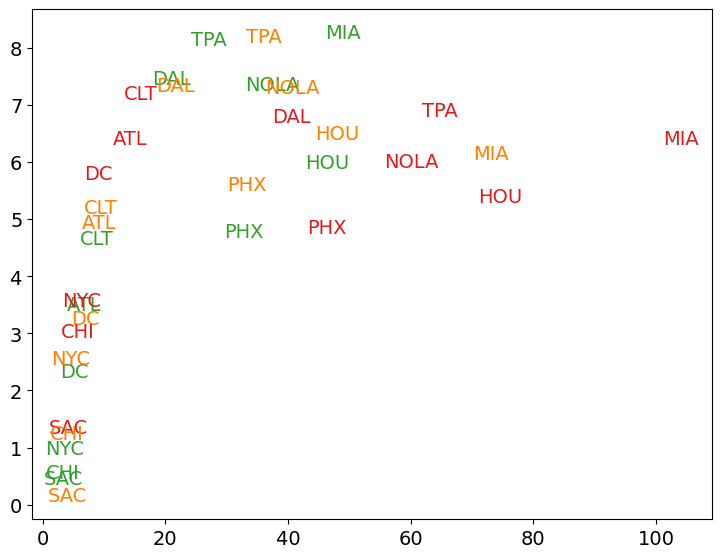

In [13]:
colors = ['#33a02c','#ff7f00','#e31a1c']
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(8,6))
gs1 = gridspec.GridSpec(1,1) #rgiSize[2])
gs1.update(left=0.1, right=0.95,
           bottom=0.1, top=0.95,
           wspace=0.75, hspace=0.60)
ax = plt.subplot(gs1[0,0])
for cy in range(len(cities_sel)):
    for wl in range(3):
        ax.scatter(np.nanpercentile(city_hw_length[cy,:,wl], (50), axis=0), 
                np.nanpercentile(city_hw_freq[cy,:,wl], (50), axis=0), 
                s=0)
        ax.text(np.nanpercentile(city_hw_length[cy,:,wl], (50), axis=0), 
                np.nanpercentile(city_hw_freq[cy,:,wl], (50), axis=0), 
                city_acronyms[cy],
                #fontsize=12,
                color=colors[wl], label=cities_sel[cy],
                ha='center', va='center')
#plt.legend()
plt.show()

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: annual-max-WBGT_change.pdf


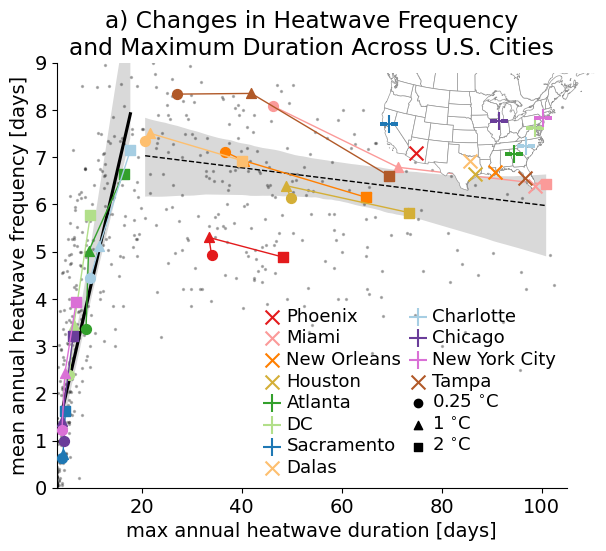

In [14]:
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#DA70D6','#b15928']
colors = ['#e31a1c','#fb9a99','#ff7f00','#d4af37','#33a02c','#b2df8a','#1f78b4','#fdbf6f','#a6cee3','#6a3d9a','#DA70D6','#b15928']

makersym = ['o','^','s']
markername = ['0.25 $^{\circ}$C','1 $^{\circ}$C','2 $^{\circ}$C']
plt.rcParams.update({'font.size': 14})
ci_sel = np.array([0,0,0,0,1,1,1,0,1,1,1,0])

fig = plt.figure(figsize=(6,5))
gs1 = gridspec.GridSpec(1,1) #rgiSize[2])
gs1.update(left=0.1, right=0.95,
           bottom=0.1, top=0.95,
           wspace=0.75, hspace=0.60)
ax = plt.subplot(gs1[0,0])

plt.scatter(city_hw_length[:,:,:].flatten(),
           city_hw_freq[:,:,:].flatten(),
           s=2, color="k", alpha=0.25)

# plot linear regression
sns.regplot(x=np.nanmean(city_hw_length[ci_sel == 1,:,:], axis=1).flatten(), 
            y=np.nanmean(city_hw_freq[ci_sel == 1,:,:], axis=1).flatten(), 
            ax=ax, scatter=False, ci=95, color="black", line_kws={'label':"Linear Fit (95% CI)"},
            scatter_kws={'zorder': 0})
xx = np.nanmean(city_hw_length[ci_sel == 1,:,:], axis=1).flatten()
yy = np.nanmean(city_hw_freq[ci_sel == 1,:,:], axis=1).flatten()
fin = ~np.isnan(xx)
dN, kN = np.polyfit(xx[fin], 
                    yy[fin],1)
sns.regplot(x=np.nanmean(city_hw_length[ci_sel == 0,:,:], axis=1).flatten(), 
            y=np.nanmean(city_hw_freq[ci_sel == 0,:,:], axis=1).flatten(), 
            ax=ax, scatter=False, ci=95, color="black", line_kws={'linewidth': 1, 'linestyle': 'dashed', 'zorder': 1},
            scatter_kws={'zorder': 0})
xx = np.nanmean(city_hw_length[ci_sel == 1,:,:], axis=1).flatten()
yy = np.nanmean(city_hw_freq[ci_sel == 0,:,:], axis=1).flatten()
fin = ~np.isnan(xx)           
dS, kS = np.polyfit(xx[fin], 
                    yy[fin], 1)

for cy in range(len(cities_sel)):
    for wl in range(3):
        ax.scatter(np.nanmean(city_hw_length[cy,:,wl], axis=0), 
                np.nanmean(city_hw_freq[cy,:,wl], axis=0), 
                s=50,
                color=colors[cy],
                marker=makersym[wl],
                zorder=4)

    # connect the different warming levels with colored lins
    plt.plot(np.nanmean(city_hw_length[cy,:,:], axis=0), 
             np.nanmean(city_hw_freq[cy,:,:], axis=0),
             color = colors[cy],
             lw=1,
             zorder=4)

    if ci_sel[cy] == 0:
        plt.scatter([],[], 
                 color = colors[cy],
                 label= cities[cy],
                 marker="x", s=100)
    else:
        plt.scatter([],[], 
                 color = colors[cy],
                 label= cities[cy],
                 marker="+", s=170)

for wl in range(3):
    plt.scatter([],[], 
             color = "k",
             label= markername[wl],
             marker=makersym[wl])



#plt.legend(ncol=2, fontsize=12)

legend = plt.legend(
    fontsize=13,       
    loc="lower right", 
    ncol=2,            
    frameon=False,      # Remove legend box
    handletextpad=0.2,  # Reduce space between marker and text
    borderpad=0.1,      # Reduce padding inside legend box
    columnspacing=0.3,  # Reduce space between columns
    handlelength=1.2,   # Reduce marker line length
    labelspacing=0.2,   # Reduce space between rows
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('mean annual heatwave frequency [days]')
plt.xlabel('max annual heatwave duration [days]')
plt.xlim(3, 105)
plt.ylim(0, 9)
ax.set_title('a) Changes in Heatwave Frequency\nand Maximum Duration Across U.S. Cities')


# === Inset Map (CONUS with City Markers) ===
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.feature as cfeature

ax_inset = plt.axes(projection=ccrs.LambertConformal())
ax_inset.set_position([0.60, 0.60, 0.4, 0.4])
# Set up Cartopy projection for inset
ax_inset.set_extent([-125, -65, 23, 50], crs=ccrs.PlateCarree())  # Focus on CONUS

# Add U.S. outline
ax_inset.add_feature(cfeature.STATES, 
                     edgecolor='#969696', 
                     facecolor='white',     # Fill states with white
                     linewidth=0.5, 
                     zorder=3)

# Plot city markers
ii = 0
for (city, (lat, lon)), selected in zip(city_locations.items(), ci_sel):
    if selected == 0:  # Filtering based on ci_sel
        ax_inset.scatter(lon, lat, color=colors[ii], 
                         s=100, marker='x', edgecolor=colors[ii], zorder=4,
                         transform=ccrs.PlateCarree())
    if selected == 1:  # Filtering based on ci_sel
        ax_inset.scatter(lon, lat, color=colors[ii], 
                         s=170, marker="+", edgecolor=colors[ii], zorder=4,
                         transform=ccrs.PlateCarree())
    ii += 1  # Increment index only for selected items
    
# Remove gridlines
ax_inset.axis("off")
ax_inset.set_xticks([])
ax_inset.set_yticks([])

sPlotFile=""
sPlotName= 'annual-max-WBGT_change.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

In [18]:
dN, kN

(0.4605577255921778, -0.25389653970531334)

In [19]:
dS, kS

(-0.1776351628821879, 8.039250458769915)

In [17]:
stop()

--Call--
> /glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/IPython/core/displayhook.py(258)__call__()
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 



ipdb>  exit


### Read in houlry WBGT over city regions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cities_sel = ['Phoenix',
          'Miami',
          # 'Atlanta',
          'New York City',
            ]

urb_cat = ["urban","rural"]

import string
abc_array = list(string.ascii_lowercase) + list(string.ascii_uppercase)

# Create a figure and an axis
fig = plt.figure(figsize=(18,3.5*len(cities_sel)))
gs1 = gridspec.GridSpec(len(cities_sel),3) #rgiSize[2])
gs1.update(left=0.06, right=0.35,
           bottom=0.13, top=0.97,
           wspace=0.75, hspace=0.60)

gs2 = gridspec.GridSpec(len(cities_sel)*2,1) #rgiSize[2])
gs2.update(left=0.355, right=0.52, #98,
           bottom=0.13, top=0.97,
           wspace=0.30, hspace=1)

gs3 = gridspec.GridSpec(len(cities_sel),1) #rgiSize[2])
gs3.update(left=0.6, right=0.75, #98,
           bottom=0.13, top=0.97,
           wspace=0.30, hspace=0.60)

for cc in tqdm(range(len(cities_sel))):
    city = cities_sel[cc]
    cy = cities.index(city)
    save_dir = save_dir_base + city + '/'
    LU_city = LU[city_loc[cy][1][0]:city_loc[cy][1][1],
             city_loc[cy][0][0]:city_loc[cy][0][1]]
    
    # # ================================================
    # # Load data
    data_ctr = xr.open_dataset(save_dir+"/CONUS404_ctr_"+cities[cy]+"_statistics.nc")
    time_ctr = pd.to_datetime(data_ctr.time.values)
    lat = data_ctr.latitude.values
    lon = data_ctr.longitude.values
    wcrp_ctr = data_ctr.WBGT.values
    
    # load PGW data
    data_pgw = xr.open_dataset(save_dir+"/CONUS404_pgw_"+cities[cy]+"_statistics.nc")
    time_pgw = pd.to_datetime(data_pgw.time.values)
    lat = data_pgw.latitude.values
    lon = data_pgw.longitude.values
    wcrp_pgw = data_pgw.WBGT.values
    
    # load variable attribution results
    change_var_categories = ['T2','Q2','PSFC','UV10', 'LW', 'SW']
    change_cat_colors = ['#e31a1c','#1f78b4','#969696','#33a02c','#a6cee3','#fb9a99']
    savefile =  '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/city_changes/' + cities[cy] + '_50gc_statistics_urban-rural_2C.npz'
    try:
        data_cy = np.load(savefile)
    except:
        print("    !!! file not found "+savefile)
        continue
    change_sensitivities = data_cy['change_sensitivities_city']
    ctr_original_data = data_cy['ctr_original_data_city']
    pgw_original_data= data_cy['pgw_original_data_city']
    
    
    # # ================================================
    # # Histogram plots
    
    ax = plt.subplot(gs1[cc,:2])
    # Plot using sns.kdeplot
    custom_bin_edges = np.arange(-40,50,0.1)
    
    # historic climate
    time_foc = np.in1d(time_c404_ctr.year, targ_ref)
    normalize = len(targ_ref) * np.sum(LU_city.values == 13)
    data_act = (wcrp_ctr[time_foc,:][:,LU_city == 13][:,::1] - 273.15).flatten()
    bfd_fre_ref = np.sum(data_act > 32.2222)/normalize
    ax. hist(
        data_act,
        bins=custom_bin_edges,
        density=True,
        zorder=5,
        edgecolor="k",
        alpha=1,
        histtype='step',
        label = '0.25 $^{\circ}$C'
    )
    
    # 1C warming
    time_foc = np.in1d(time_c404_ctr.year, targ_1C)
    normalize = len(targ_1C) * np.sum(LU_city.values == 13)
    data_act = (wcrp_ctr[time_foc,:][:,LU_city == 13][:,::1] - 273.15).flatten()
    bfd_fre_1C = np.sum(data_act > 32.2222)/normalize
    ax.hist(
        data_act,
        bins=custom_bin_edges,
        density=True,
        zorder=5,
        edgecolor="b",
        alpha=1,
        histtype='step',
        label = '1 $^{\circ}$C | '+ str(int(((bfd_fre_1C - bfd_fre_ref)/bfd_fre_ref)*100))+' %'
    )
    
    # 2C climate
    time_foc = np.in1d(time_c404_pgw.year, targ_2C)
    normalize = len(targ_2C) * np.sum(LU_city.values == 13)
    data_act = (wcrp_pgw[time_foc,:][:,LU_city == 13][:,::1] - 273.15).flatten()
    bfd_fre_2C = np.sum(data_act > 32.2222)/normalize
    ax.hist(
        data_act,
        bins=custom_bin_edges,
        density=True,
        zorder=5,
        edgecolor="r",
        alpha=1,
        histtype='step',
        label = '2 $^{\circ}$C | '+ str(int(((bfd_fre_2C - bfd_fre_ref)/bfd_fre_ref)*100))+' %'
    )
    
    ax.set_xlim([25, 44])
    ax.set_yscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.axvline(x=26.6667, c = '#33a02c', ls = ':')
    plt.axvline(x=29.4444, c = '#ffed6f', ls = ':')
    plt.axvline(x=31.1111, c = '#e31a1c', ls = ':')
    plt.axvline(x=32.2222, c = 'k', ls = ':')

    plt.legend() 
    # Customize the plot as needed
    ax.set_title(abc_array[cc*5]+') hourly WBGT PDF '+cities[cy])

    # Add row title (centered text on the left of the row)
    ax.text(-0.2, 0.5, cities_sel[cc], fontsize=15, fontweight="bold",
            rotation=90, ha="center", va="center", transform=ax.transAxes)
    
    # ================================================
    print("    Variable attribution")
    ax = plt.subplot(gs1[cc,2])
    for cr in [0]: #range(len(urb_cat)):
        # city=0, rural=1
        mean_change = np.nanmedian(pgw_original_data[:,:,cr]) - np.nanmedian(ctr_original_data[:,:,cr])
        
        plt.plot([0.1+cr,0.1+cr],[0,mean_change], c='k', lw=1)
        plt.plot([0.9+cr,0.9+cr],[0,mean_change], c='k', lw=1)
        plt.plot([0.1+cr,0.9+cr],[mean_change,mean_change], c='k', lw=3)
        
        # Add the components from different variables
        orig_change = np.nanmedian(pgw_original_data[:,:,cr]) - np.nanmedian(ctr_original_data[:,:,cr])
        mean_change_vars = (np.nanmedian(change_sensitivities[:,:,:,cr], axis=(0,1)) - np.nanmedian(ctr_original_data[:,:,cr]))
        change_deltas = orig_change - (np.nanmedian(change_sensitivities[:,:,:,cr], axis=(0,1)) - np.nanmedian(ctr_original_data[:,:,cr]))
        
        for va in range(change_sensitivities.shape[2]):
            if va == 0:
                start = 0
            else:
                start = np.sum(change_deltas[:va])
            plt.arrow(0.3+0.1*va+cr, start, 0, np.sum(change_deltas[:va+1])-start, length_includes_head=True,
                      head_width=0.1, head_length=0.05,
                      color=change_cat_colors[va],
                      lw=3)
        
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 2)
        
        for va in range(change_sensitivities.shape[2]):
            plt.plot([],[], label = change_var_categories[va], lw = 3, color = change_cat_colors[va])
    
        if (cc == 0) & (cr == 0):
            plt.legend(ncol=2)
        
    ax.set_xticks([0.5])#,1.5])
    ax.set_xticklabels([cities_sel[cc]], rotation=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylabel('annual max. WBGT change [K]')
    ax.set_title(abc_array[cc*5+1]+') WBGT change at\n2$^{\circ}$C warming')

    
    # ================================================
    # Annual cycle of black flag days
    ax = plt.subplot(gs2[cc*2,0], polar=True, zorder=cc)
    from math import pi
    original_position = ax.get_position()  # Returns Bbox object    
    # Expand the axis position (left, bottom, width, height)
    new_position = [
        original_position.x0 ,  # Shift left a bit
        original_position.y0 -0.05 ,  # Shift down a bit
        original_position.width * 2,  # Increase width
        original_position.height * 2,  # Increase height
    ]
    ax.set_position(new_position)
    
    # number of variable
    categories=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    N = 12
     
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
     
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)
     
    # Draw ylabels
    ax.set_rlabel_position(0)
    # plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    # plt.ylim(0,40)
    
    # 0.25 C
    seasonal_cycle = np.zeros((12)); seasonal_cycle[:] = np.nan
    normalize = len(targ_ref) * np.sum(LU_city.values == 13)
    for mm in range(12):
        time_foc = (np.in1d(time_c404_ctr.year, targ_ref)) & (time_c404_ctr.month == mm+1)
        seasonal_cycle[mm] = np.sum((wcrp_ctr[time_foc,:][:,LU_city == 13]).flatten() > 305.372) / normalize
    values=seasonal_cycle.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label="0.25 C", color='k')
    # ax.fill(angles, values, 'b', alpha=0.1)
    
    # 1 C
    seasonal_cycle = np.zeros((12)); seasonal_cycle[:] = np.nan
    normalize = len(targ_1C) * np.sum(LU_city.values == 13)
    for mm in range(12):
        time_foc = (np.in1d(time_c404_ctr.year, targ_1C)) & (time_c404_ctr.month == mm+1)
        seasonal_cycle[mm] = np.sum((wcrp_ctr[time_foc,:][:,LU_city == 13]).flatten() > 305.372) / normalize
    values=seasonal_cycle.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label="1 C", color='b')
    
    # 2 C
    seasonal_cycle = np.zeros((12)); seasonal_cycle[:] = np.nan
    normalize = len(targ_2C) * np.sum(LU_city.values == 13)
    for mm in range(12):
        time_foc = (np.in1d(time_c404_pgw.year, targ_2C)) & (time_c404_pgw.month == mm+1)
        seasonal_cycle[mm] = np.sum((wcrp_pgw[time_foc,:][:,LU_city == 13]).flatten() > 305.372) / normalize
    values=seasonal_cycle.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label="2 C", color='r')

    ax.set_thetamin(90)
    ax.set_thetamax(270)
    ax.tick_params(axis='y', rotation=45)
    ax.set_title(abc_array[cc*5+2]+') Seasonal cycle of BF day frequency', pad=-10)
    
    # ================================================
    # Diurnal cycle of black flag days
    ax = plt.subplot(gs2[cc*2+1,0], polar=True, zorder=cc)
    from math import pi
    original_position = ax.get_position()  # Returns Bbox object    
    # Expand the axis position (left, bottom, width, height)
    new_position = [
        original_position.x0 ,  # Shift left a bit
        original_position.y0 -0.05, #-0.2 ,  # Shift down a bit
        original_position.width * 2,  # Increase width
        original_position.height * 2,  # Increase height
    ]
    ax.set_position(new_position)
    
    # number of variable
    utc_diff = int(np.round(solar_time_difference_from_utc(np.mean(lon)).total_seconds() / 3600, 0))
    categories= np.array(range(24))
    N = 24
     
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
     
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)
     
    # Draw ylabels
    ax.set_rlabel_position(0)
    # plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    # plt.ylim(0,40)
    
    # 0.25 C
    diurnal_cycle = np.zeros((24)); seasonal_cycle[:] = np.nan
    normalize = len(targ_ref) * np.sum(LU_city.values == 13)
    for hh in range(24):
        time_foc = (np.in1d(time_c404_ctr.year, targ_ref)) & (time_c404_ctr.hour == hh+1)
        diurnal_cycle[hh] = np.sum((wcrp_ctr[time_foc,:][:,LU_city == 13]).flatten() > 305.372) / normalize
    diurnal_cycle =  np.roll(diurnal_cycle, utc_diff)
    values=diurnal_cycle.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label="0.25 C", color='k')
    # ax.fill(angles, values, 'b', alpha=0.1)
    
    # 1 C
    diurnal_cycle = np.zeros((24)); seasonal_cycle[:] = np.nan
    normalize = len(targ_1C) * np.sum(LU_city.values == 13)
    for hh in range(24):
        time_foc = (np.in1d(time_c404_ctr.year, targ_1C)) & (time_c404_ctr.hour == hh+1)
        diurnal_cycle[hh] = np.sum((wcrp_ctr[time_foc,:][:,LU_city == 13]).flatten() >= 305.372) / normalize
    diurnal_cycle =  np.roll(diurnal_cycle, utc_diff)
    values=diurnal_cycle.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label="1 C", color='b')
    
    
    # 2 C
    diurnal_cycle = np.zeros((24)); seasonal_cycle[:] = np.nan
    normalize = len(targ_2C) * np.sum(LU_city.values == 13)
    for hh in range(24):
        time_foc = (np.in1d(time_c404_pgw.year, targ_2C)) & (time_c404_pgw.hour == hh+1)
        diurnal_cycle[hh] = np.sum((wcrp_pgw[time_foc,:][:,LU_city == 13]).flatten() > 305.372) / normalize
    diurnal_cycle =  np.roll(diurnal_cycle, utc_diff)
    values=diurnal_cycle.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label="2 C", color='r')

    ax.set_thetamin(90)
    ax.set_thetamax(270)
    ax.tick_params(axis='y', rotation=45)
    
    if cc == 0:
        plt.legend() #loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax.set_title(abc_array[cc*5+3]+') Diurnal cycle of BF hour frequency', pad=-10)
    
    # ================================================
    # Heatwave length and frequency
    ax = plt.subplot(gs3[cc,0])
    sns.set_style("white")
    
    def heatwave_stat(data,
                      time_hh,
                     targ_ref,
                     LU_city):
        max_len = np.zeros(len(targ_ref))
        av_freq = np.zeros(len(targ_ref))
        for yy in range(len(targ_ref)):
            time_foc = (np.in1d(time_hh.year, targ_ref[yy]))
            data_year = np.max(data[time_foc,:][:,LU_city == 13], axis = 1)
            data_year = np.max(np.reshape(data_year, (int(data_year.shape[0]/24), 24)), axis = 1)
            label_im, nb_labels = ndimage.label(data_year >= 305.372)
            objects = scipy.ndimage.find_objects(label_im)
            try:
                max_len[yy] = np.max([objects[ii][0].stop - objects[ii][0].start for ii in range(len(objects))])
            except:
                continue
            av_freq[yy] = nb_labels-1
        return max_len, av_freq
    
    # 0.25 C
    max_len, av_freq = heatwave_stat(wcrp_ctr, time_c404_ctr, targ_ref, LU_city)
    # ax.plot(np.percentile(max_len, (0,100)), [np.median(av_freq), np.median(av_freq)], c = 'k')
    sns.kdeplot(x=max_len, y=av_freq, cmap="Greys", fill=True, alpha=0.5, lw=0)
    plt.errorbar(np.median(max_len), np.median(av_freq), 
                 xerr=[[np.median(max_len)-np.percentile(max_len, (10))],[np.percentile(max_len, (90))-np.median(max_len)]], 
                 yerr=[[np.median(av_freq)-np.percentile(av_freq, (10))],[np.percentile(av_freq, (90))-np.median(av_freq)]], 
                 fmt='o', c='k', capsize=5, capthick=1)
    
    # 1 C
    max_len, av_freq = heatwave_stat(wcrp_ctr, time_c404_ctr, targ_1C, LU_city)
    # ax.plot(np.percentile(max_len, (0,100)), [np.median(av_freq), np.median(av_freq)], c = 'k')
    # sns.kdeplot(x=max_len, y=av_freq, cmap="Blues", fill=True, alpha=0.5)
    plt.errorbar(np.median(max_len), np.median(av_freq), 
                 xerr=[[np.median(max_len)-np.percentile(max_len, (10))],[np.percentile(max_len, (90))-np.median(max_len)]], 
                 yerr=[[np.median(av_freq)-np.percentile(av_freq, (10))],[np.percentile(av_freq, (90))-np.median(av_freq)]], 
                 fmt='o', c='b', capsize=5, capthick=1)
    
    # 2 C
    max_len, av_freq = heatwave_stat(wcrp_pgw, time_c404_pgw, targ_2C, LU_city)
    # ax.plot(np.percentile(max_len, (0,100)), [np.median(av_freq), np.median(av_freq)], c = 'k')
    sns.kdeplot(x=max_len, y=av_freq, cmap="Reds", fill=False, alpha=0.5)
    plt.errorbar(np.median(max_len), np.median(av_freq), 
                 xerr=[[np.median(max_len)-np.percentile(max_len, (10))],[np.percentile(max_len, (90))-np.median(max_len)]], 
                 yerr=[[np.median(av_freq)-np.percentile(av_freq, (10))],[np.percentile(av_freq, (90))-np.median(av_freq)]], 
                 fmt='o', c='r', capsize=5, capthick=1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.xlim(0, 60)
    plt.ylim(0, 45)
    
    plt.xlabel('annual max. heatwave length [days]')
    plt.ylabel('number of heatwaves per year')
    ax.set_title(abc_array[cc*5+4]+') Heatwave length and frequency')

sPlotFile=""
sPlotName= 'city_heatwaves.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)

In [ ]:
sns.set_style("white")
sns.kdeplot(x=max_len, y=av_freq, cmap="Reds", fill=False, alpha=0.5)
plt.show()

In [ ]:
stop()

In [ ]:
pgw_data = np.zeros((len(years_pgw),12,lon_conus.shape[0],lon_conus.shape[1])); pgw_data[:] = np.nan
pgw_time = np.empty((len(years_pgw),12,lon_conus.shape[0],lon_conus.shape[1]), dtype='datetime64[s]')

In [ ]:
for yy in tqdm(range(len(years_pgw))):
    for mm in range(12):
        datafile = data_dir + str(years_pgw[yy]) + str(mm+1).zfill(2) +'_WBGT_monmax_variables_pgw.npz'
        if os.path.isfile(datafile) == True:
            data = np.load(datafile)
            pgw_data[yy,mm,:,:] = data['conus_ctr'][:,:,0]
            pgw_time[yy,mm,:] = data['timestamp_max']

In [ ]:
month_max = np.nanargmax(ctr_data[:,:,:,:], axis=1)
y,la,lo = np.indices(ctr_data[:,0,:,:].shape)

ymax_ctr = np.copy(ctr_data[:,0,:,:]); ymax_ctr[:]=np.nan
ymax_ctr[:,:,:] = ctr_data[y, month_max, la, lo]
ytime_ctr = ctr_time[y, month_max, la, lo]

In [ ]:
month_max = np.nanargmax(pgw_data[:,:,:,:], axis=1)
y,la,lo = np.indices(pgw_data[:,0,:,:].shape)

ymax_pgw = np.copy(pgw_data[:,0,:,:]); ymax_pgw[:]=np.nan
ymax_pgw[:,:,:] = pgw_data[y, month_max, la, lo]
ytime_pgw = pgw_time[y, month_max, la, lo]

In [ ]:
plt.plot(np.nanmean(np.nanmax(pgw_data[:,:,:,:], axis=(1)), axis=(1,2))-273.15, c='r')
plt.plot(np.nanmean(np.nanmax(ctr_data[:,:,:,:], axis=(1)), axis=(1,2))-273.15, c='b')

plt.show()
# plt.plot(c_pgw_years, np.nanmean(conus_pgw_wbgt, axis=(1,2))-273.15, c='r')

In [ ]:
fut = np.nanmean(np.nanmax(pgw_data[:,:,:,:], axis=(1)), axis=(1,2))-273.15
cur = np.nanmean(np.nanmax(ctr_data[:,:,:,:], axis=(1)), axis=(1,2))-273.15
plt.plot(fut - cur[:len(fut)], c='k')
plt.show()

### Load hourly data over city and derive statistics

In [ ]:
datasets = ['CONUS404_ctr', 'CONUS404_pgw']
flag_thresholds = [29, 31, 32]

lat_cy = lat_conus[city_loc[cy][1][0]:city_loc[cy][1][1],
                   city_loc[cy][0][0]:city_loc[cy][0][1]]
lon_cy = lon_conus[city_loc[cy][1][0]:city_loc[cy][1][1],
                   city_loc[cy][0][0]:city_loc[cy][0][1]]

In [ ]:
for da in [1]: #range(len(datasets)):
    print('WORK ON '+datasets[da])
    outfile = save_dir + datasets[da] + '_'+city+'_statistics.nc'
    if os.path.isfile(outfile) == False:
        if datasets[da] == 'CONUS404_ctr':
            data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/GWBT/'
            time = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                                  end=datetime.datetime(2022, 12, 31, 23), freq='h')
            data_cy = np.zeros((len(time), lat_cy.shape[0], lat_cy.shape[1]))
            years = np.unique(time.year)
            for yy in tqdm(range(len(years))):
                for mm in range(12):
                    time_act = (years[yy] == time.year) & (mm+1 == time.month)
                    file = data_dir + 'GWBT_'+str(years[yy])+str(mm+1).zfill(2)+'_CONUS404.nc'
                    ncid=Dataset(file, mode='r')
                    data_cy[time_act,:] = np.array(np.squeeze(ncid.variables['GWBT'][:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                                                             city_loc[cy][0][0]:city_loc[cy][0][1]]))
                    ncid.close()
    
        elif datasets[da] == 'CONUS404_pgw':
            data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/GWBT/'
            time = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                                  end=datetime.datetime(2011, 12, 31, 23), freq='h')
            data_cy = np.zeros((len(time), lat_cy.shape[0], lat_cy.shape[1]))
            years = np.unique(time.year)
            for yy in tqdm(range(len(years))):
                for mm in range(12):
                    time_act = (years[yy] == time.year) & (mm+1 == time.month)
                    file = data_dir + 'GWBT_'+str(years[yy])+str(mm+1).zfill(2)+'_CONUS404.nc'
                    ncid=Dataset(file, mode='r')
                    data_cy[time_act,:] = np.array(np.squeeze(ncid.variables['__xarray_dataarray_variable__'][:,city_loc[cy][1][0]:city_loc[cy][1][1],
                                                                             city_loc[cy][0][0]:city_loc[cy][0][1]]))
                    ncid.close()
    
                

    ds = xr.Dataset(
        {
            "WBGT": (["time", "y", "x"], data_cy)
        },
        coords={
            "time": time,
            "y": np.arange(lat_cy.shape[0]),
            "x": np.arange(lat_cy.shape[1]),
            "latitude": (["y", "x"], lat_cy),
            "longitude": (["y", "x"], lon_cy)
        }
    )
    
    # Set attributes (optional but recommended)
    ds.attrs['long_name'] = 'Wet bulb globe temperature dimensions time, latitude, longitude'
    ds['WBGT'].attrs['units'] = 'K'
    
    # Write to a NetCDF file
    ds.to_netcdf(outfile)
    
    print(f"Data successfully written to {outfile}")